In [29]:
%load_ext autoreload
%autoreload 2

#Misc
import os, sys, pdb
from glob import glob

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Allen
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import raster_plot,plot_spike_counts

# #User
import util
# import plotting as usrplt
# import decoding as dc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# This path is where the data will be stored
manifest_path = os.path.join("/media/Allen_Institute_Data", "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

#Get the session dataframe
sessions = cache.get_session_table()


In [3]:
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]

# areas_of_interest = ['VISp','VISl','VISrl','LP','VISal','VISpm','VISam','CA1']
# for session_ID in brain_observatory_type_sessions.index.values:
#     areas_recorded = brain_observatory_type_sessions.loc[session_ID]['ecephys_structure_acronyms']
    
    
brain_observatory_type_sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


In [4]:
# We are going to pick a session arbitrarily and download its spike data.
session_id = 715093703#791319847
session = cache.get_session_data(session_id)

#Show relevant data about experiment
session.metadata

{'specimen_name': 'Sst-IRES-Cre;Ai32-386129',
 'session_type': 'brain_observatory_1.1',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'sex': 'M',
 'age_in_days': 118.0,
 'rig_equipment_name': 'NP.1',
 'num_units': 884,
 'num_channels': 2219,
 'num_probes': 6,
 'num_stimulus_presentations': 70388,
 'session_start_time': datetime.datetime(2019, 1, 19, 0, 54, 18, tzinfo=tzoffset(None, -28800)),
 'ecephys_session_id': 715093703,
 'structure_acronyms': ['PO',
  'PoT',
  'LP',
  'DG',
  'CA1',
  'VISp',
  nan,
  'LGd',
  'CA3',
  'VISl',
  'VISrl',
  'grey',
  'VISpm',
  'VISam',
  'APN',
  'MB'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings',
  'natural_movie_three',
  'natural_movie_one',
  'static_gratings',
  'natural_scenes']}

In [5]:
#We can also take a look at how many units were recorded in each brain structure:
session.structurewise_unit_counts

CA1      145
LP       139
grey     117
LGd       82
PO        76
VISrl     76
VISp      60
VISpm     50
VISl      42
VISam     30
DG        26
APN       26
CA3       14
PoT        1
Name: ecephys_structure_acronym, dtype: int64

In [6]:
#Let's look at neurons in CA1
AM_units = session.units[session.units["ecephys_structure_acronym"] == 'CA1'].index.values

#Get the stimulus dataframe for one of the natural movie presentations
stimulus_df = session.get_stimulus_table("natural_movie_three")
stimulus_df.head()


,contrast,frame,orientation,size,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
3999,1,0,0,"[1920.0, 1080.0]",2205.301633,3,natural_movie_three,2205.334993,0.03336,287
4000,1,1,0,"[1920.0, 1080.0]",2205.334993,3,natural_movie_three,2205.368354,0.03336,288
4001,1,2,0,"[1920.0, 1080.0]",2205.368354,3,natural_movie_three,2205.401714,0.03336,289
4002,1,3,0,"[1920.0, 1080.0]",2205.401714,3,natural_movie_three,2205.435075,0.03336,290
4003,1,4,0,"[1920.0, 1080.0]",2205.435075,3,natural_movie_three,2205.468435,0.03336,291


/home/luca/ssm_env/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


Text(0, 0.5, 'Neuron ID')

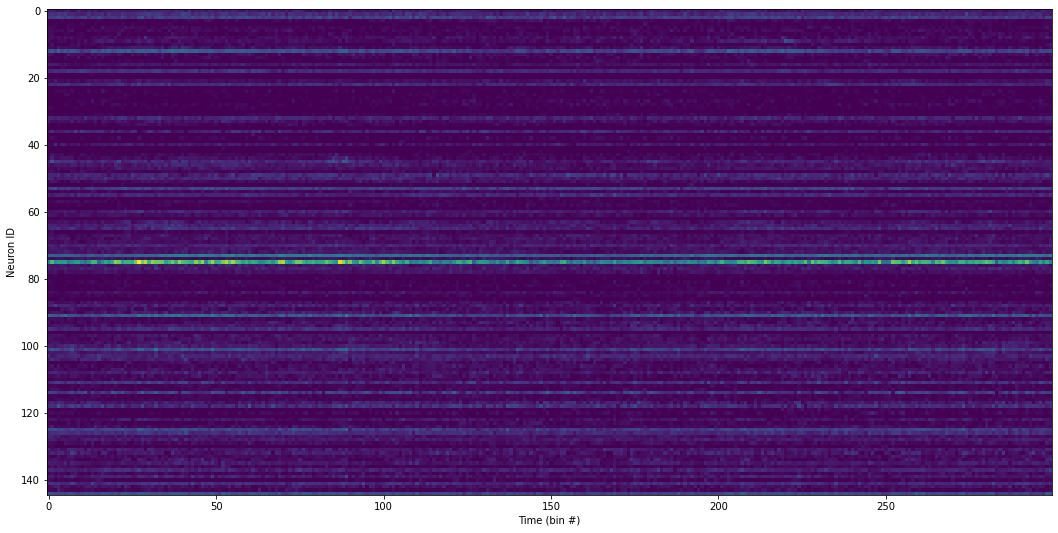

In [30]:
#Create a spike count array for the natural movie presentation
spike_counts_xr, start_times  = util.get_presentationwise_spike_counts_natural_movies(session, bSize=0.1, stimulus='natural_movie_three', unit_ids=AM_units)

#The movie was presented 10 times; each movie is 30 seconds long (300 bins of 100ms)
spike_counts_xr.coords

#We can plot a PSTH of sorts if we want
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(np.mean(spike_counts_xr,axis=0).T,cmap='viridis')
plt.xlabel('Time (bin #)'); plt.ylabel('Neuron ID')

In [31]:
spike_counts_xr

<xarray.DataArray 'spike_counts' (movie_presetation_id: 10, time_relative_to_stimulus_onset: 300, unit_id: 145)>
array([[[ 0,  0,  2, ...,  0,  0,  2],
        [ 0,  0,  2, ...,  2,  0,  3],
        [ 0,  1,  2, ...,  1,  0,  3],
        ...,
        [ 1,  1,  3, ...,  1,  0,  3],
        [ 1,  1,  2, ...,  0,  0,  2],
        [ 3,  0,  1, ...,  2,  0,  5]],

       [[ 1,  2,  2, ...,  1,  1,  6],
        [ 0,  4,  1, ...,  3,  1,  5],
        [ 2,  1,  0, ...,  2,  0,  3],
        ...,
        [ 4,  0,  0, ...,  0,  0,  0],
        [ 6,  1,  3, ...,  1,  1,  2],
        [ 0,  1, 10, ...,  0,  0,  7]],

       [[ 0,  4,  5, ...,  0,  1,  6],
        [ 2,  3,  1, ...,  1,  2,  3],
        [ 1,  1,  2, ...,  0,  0,  4],
        ...,
        [ 2,  0,  1, ...,  2,  0,  3],
        [ 0,  1,  3, ...,  0,  0,  8],
        [ 2,  1,  0, ...,  0,  0,  2]],

       ...,

       [[ 0,  0,  4, ...,  0,  0,  4],
        [ 0,  3,  4, ...,  0,  0,  1],
        [ 0,  2,  1, ...,  0,  0,  1],
        ...,
        [ 1,  0,  0, ...,  0,  0,  1],
        [ 1,  1,  2, ...,  0,  0,  4],
        [ 3,  1,  2, ...,  0,  0,  2]],

       [[ 0,  2,  2, ...,  0,  0,  2],
        [ 0,  1,  2, ...,  0,  0,  1],
        [ 2,  1,  1, ...,  0,  0,  3],
        ...,
        [ 2,  2,  0, ...,  1,  0,  1],
        [ 0,  1,  2, ...,  0,  0,  4],
        [ 0,  0,  3, ...,  0,  0,  0]],

       [[ 3,  1,  1, ...,  0,  0,  2],
        [ 3,  1,  2, ...,  0,  0,  3],
        [ 0,  3,  5, ...,  1,  0,  3],
        ...,
        [ 1,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  5, ...,  0,  0,  3],
        [ 0,  0,  0, ...,  0,  0,  3]]], dtype=uint16)
Coordinates:
  * movie_presetation_id             (movie_presetation_id) int64 0 1 2 ... 8 9
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.05 ... 29.95
  * unit_id                          (unit_id) int64 950911195 ... 950955399

In [32]:
list(spike_counts_xr[::2])[0].shape

(300, 145)

In [37]:
import ssm
# from ssm.util import find_permutation
# from ssm.plots import gradient_cmap, white_to_color_cmap

nTrials, nBins, nNeurons = spike_counts_xr.shape
spike_counts_xr = spike_counts_xr.values.astype('int16')

K = 10
nKfold = 10
obs_dim = nNeurons

In [38]:
#Create poisson hidden markov model object 
hmm_allen = ssm.HMM(K, obs_dim, observations="poisson")

#Split data into training and test data
train_data = list(spike_counts_xr[::2])
test_data = list(spike_counts_xr[1::2])

#Fit data to model
train_lls = hmm_allen.fit(train_data, method="em",num_iters=10000)


AttributeError: module 'ssm' has no attribute 'HMM'

In [30]:
trMAPs =[]; trPosteriors=[]; trMasks=[]

T = 0; ll_heldout = 0
state_usage = np.zeros(K)
used_states = list(np.arange(K))

#Loop over data to obtain MAP sequence for each trial
for index, data in enumerate(test_data):
    #Get state probabilities
    Ez, _, ll = hmm_allen.expected_states(data)

    #Update number of data points, state usage, and llood of data 
    mapseq = np.argmax(Ez,axis=1)
    T += Ez.shape[0]
    state_usage += np.array([np.sum(mapseq == s) for s in used_states])
    ll_heldout += ll

    #maximum a posteriori probability estimate of states
    trMAPs.append(mapseq)
    trPosteriors.append(Ez)
    trMasks.append(np.max(Ez,axis=1) < 0.75)

#Normalize
state_usage /= T
state_usage

array([0.22133333, 0.02933333, 0.05133333, 0.17866667, 0.12666667,
       0.17      , 0.062     , 0.066     , 0.008     , 0.08666667])

Text(0, 0.5, 'Trial #')

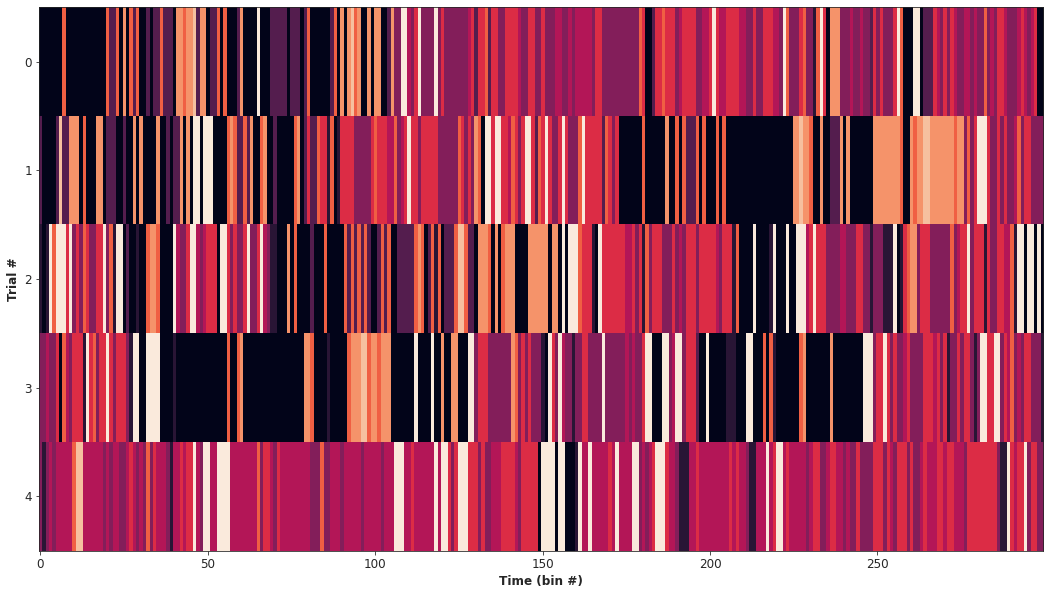

In [32]:
fig,ax = plt.subplots(figsize=(18,10))

# Plot StateSeq as a heatmap
im = ax.imshow(trMAPs, aspect='auto', vmin=0, vmax=K - 1, interpolation="nearest")
plt.xlabel('Time (bin #)'); plt.ylabel('Trial #')